# Traffic Sign Recognition Classifier

## Table of Contents
<ul>
    <li><a href="#intro">Introduction</a></li>
    <li><a href="#load">Load the data set</a></li>
    <li><a href="#eda">Explore, summarize and visualize the data set</a></li>
    <li><a href="#preprocess">Preprocess the Data</a></li>
    <li><a href="#design">Design, train and test a model architecture</a></li>
    <li><a href="#predict">Use the model to make predictions on new images</a></li>
    <li><a href="#probabilities">Analyze the softmax probabilities of predictions on the new images</a></li>
</ul>

<a id="intro"/>
---
## Introduction

In the following, we'll attempt to design a convolutional neural network to classify traffic signs. We'll use data originally obtained from the [German Traffic Sign Recognition Benchmark](http://benchmark.ini.rub.de/?section=gtsrb&subsection=news) and base our model on the that described by Sermanet and LeCun ([2011](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf)).

<a id="load"/>
---
## Load The Data

Note: this data was originally obtained from the following:

J. Stallkamp, M. Schlipsing, J. Salmen, and C. Igel. The German Traffic Sign Recognition Benchmark: A multi-class classification competition. In _Proceedings of the IEEE International Joint Conference on Neural Networks_, pages 1453–1460. 2011. 

In [1011]:
print('Reading data...')

# Load pickled data
import pickle
import os

# Set DIR as the string of the path of the folder containing each file
HOME = os.path.expanduser('~')
DIR = HOME + '/Documents/carnd-term1/CarND-Traffic-Sign-Classifier-Project/data'

# Obtain the path of each file
training_file   = DIR + '/train.p'
validation_file = DIR + '/valid.p'
testing_file    = DIR + '/test.p'

# Read each file into a variable
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
# Create train, validation, and test sets based on the read data
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

print('Data read successfully!\n\n')

# Checking that data lengths are valid
print('Checking data...')
assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
assert(len(X_test) == len(y_test))
print('Data checked and are valid')

Reading data...
Data read successfully!


Checking data...
Data checked and are valid


<a id="eda"/>
---

## Explore, summarize and visualize the data set

The data used will be loaded from a pickle. We'll calculate a few statistics and explore it a bit.

In [264]:
import numpy as np

# Find and store the number of training examples
n_train = len(X_train)

# Find and store the number of validation examples
n_validation = len(X_valid)

# Find and store the number of testing examples.
n_test = len(X_test)

# Find and store the shape of an traffic sign image.
image_shape = X_train[0].shape

# Find and store the number of unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 173995
Number of testing examples = 12630
Image data shape = (32, 32, 1)
Number of classes = 43


In [154]:
### Data exploration visualization code
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Visualizations will be shown in the notebook.
%matplotlib inline

# Find the number of instances of each unique in each image in each dataset
els, train_counts = np.unique(y_train, return_counts=True)
_, v_inds, valid_counts = np.unique(y_valid, return_index=True, return_counts=True)
_, inds, test_counts = np.unique(y_test, return_index=True, return_counts=True)

# Put the data in a dataframe
# The training set is- significantly larger than the other two sets so it would
#  seems advisable to look at relative frequencies instead.
train_count_ratios = train_counts / train_counts.sum()
valid_count_ratios = valid_counts / valid_counts.sum()
test_count_ratios = test_counts / test_counts.sum()
counts_df = pd.DataFrame({'count' : list(train_count_ratios) + \
                          list(valid_count_ratios) + list(test_count_ratios), 
                  'type' : [i for i in range(43)]*3, 
                  'set' : ['train']*43 + ['valid']*43 + ['test']*43})

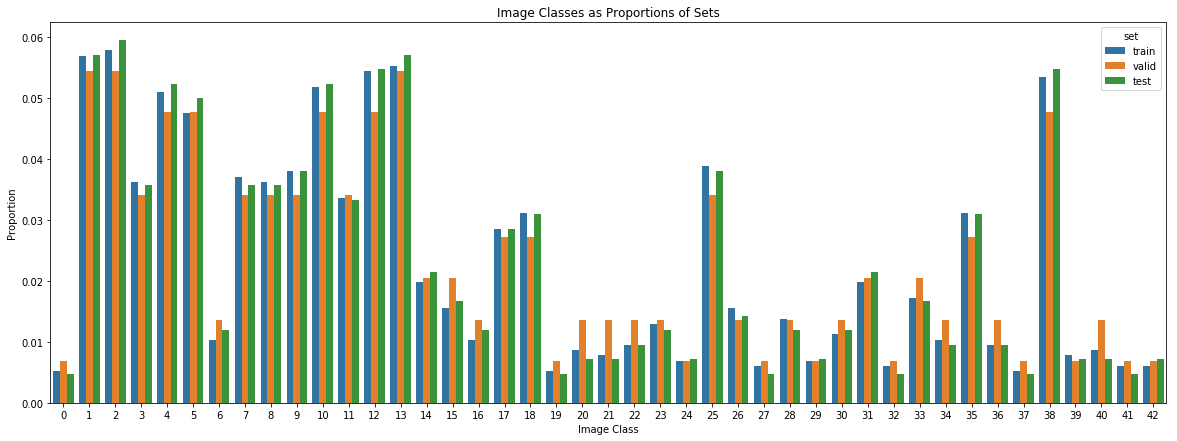

In [4]:
# # Draw a nested barplot to show the proportion of each set made up by each image class
plt.figure(figsize=(20,7))
sns.barplot(data=counts_df, x='type',y='count',hue='set')
plt.ylabel('Proportion')
plt.xlabel('Image Class')
plt.title('Image Classes as Proportions of Sets')
plt.show()

We see that each image class takes up a similar amount of the sets, so usage of these sets should be reasonable. The proportion of the train set that is made up by each image is similar to that of the test set, so the performance on the test set will be reflective of that on the train set. However, there is a relatively large difference between proportions in the test set and those in the validation set, so performance on the validation set may not be strongly reflective of performance on the train set. That is, a model that performs well on one set may not perform well on the other set. To be fair, the trends appear similar - i.e., images relatively common in the train set are also relatively common in the validation set and images relatively rare in the train set are relatively rare in the validation set, so somewhat of a degree of reflectivity between performance on each set should still be expected. Also, perfect ratio equivalence suggests a lack of randomness.

The fact that some images are more prevalent in each set (e.g., train, valid, test) suggests that a model trained on these sets will be better at classifying certain images than at classifying other images. For instance, the model will receive much training on class 13 and far less training on class 0 and so will be better at classifying images of the former class, and less proficient at classifying images of the latter class.

Let's take a look at these signs. According to `signnames.csv`, class 13 refers to a 'Yield' sign whereas class 0 refers to a "Speed limit (20km/h)" sign.

Class 13 (higher prevalence in all sets):


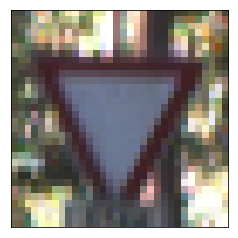

In [5]:
print('Class 13 (higher prevalence in all sets):')
plt.imshow(X_test[inds[13]])
plt.grid(True)
plt.xticks([])
plt.yticks([])
plt.show()

Class 0 (lower prevalence in all sets):


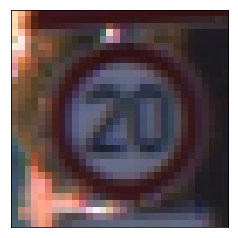

In [6]:
print('Class 0 (lower prevalence in all sets):')
plt.imshow(X_test[inds[0]])
plt.grid(True)
plt.xticks([])
plt.yticks([])
plt.show()

Now, we may look more closely at statistics of the representation in each dataset. We see that the corresponding average proportions are each close to 0.0232 ($\frac{1}{43} \approx 0.0232558$) so the mean of the sample means approaches what we would expect of the population mean if the data is randomly sampled, among other conditions. The former does not imply the latter, but if the the former did not hold (i.e., we did not see this phenomenon regarding the representation means), it would be grounds for an argument that the data is not random. Although we cannot make definitive conclusions about randomness, it is relieving to see that despite great apparent variation (e.g., the standard deviation exceeds the median), no proportions drop below 4.75%.

In [7]:
print('Statistics regarding representation in the train set:')
counts_df['count'].iloc[:43].describe()

Statistics regarding representation in the train set:


count    43.000000
mean      0.023256
std       0.018011
min       0.005173
25%       0.008190
50%       0.015518
75%       0.036639
max       0.057760
Name: count, dtype: float64

In [8]:
print('Statistics regarding representation in the validation set:')
counts_df['count'].iloc[43:86].describe()

Statistics regarding representation in the validation set:


count    43.000000
mean      0.023256
std       0.015796
min       0.006803
25%       0.013605
50%       0.013605
75%       0.034014
max       0.054422
Name: count, dtype: float64

In [9]:
print('Statistics regarding representation in the test set:')
counts_df['count'].iloc[86:].describe()

Statistics regarding representation in the test set:


count    43.000000
mean      0.023256
std       0.018483
min       0.004751
25%       0.007126
50%       0.014252
75%       0.035629
max       0.059382
Name: count, dtype: float64

With what we have found so far, it seems reasonable to move forward and develop a classifier. Performance could theoretically be improved if we ensured an equal proportion of class representation, but such would preclude true randomness and may have negative effects on performance of the classifier. Specifically, if we ensured equal representation by subtracting data, we would decrease the overall amount of training available to the classifier and intuitively, this would have a negative effect on performance. It is conceivable that performance would decrease if we only modified one dataset, such that we train on unbiased data and test with biased data, or vice versa.

To be fair, the fact that representativeness of each class is similar in all of the datasets (e.g., those that are more common in the train set are also more common in the test set and vice versa) suggests against true randomness - perhaps the proportional trends are a simple result of the results of data collection. For now, though, we will table that consideration and move ahead.

<a id="preprocess"/>
---
## Preprocess the Data

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). In their work, Sermanet and LeCun (2011) found performance was superior in the YUV color space. Specifically, they claimed to use YUV channels or Y only. In their work, they concluded that their network "could have clearly benefitted for color information for the worst errors... where an arrow is hardly visible in grayscale but clearly is in color channels. We however showed that non-normalized color yielded overall worse performance." Including color may rectify some prediction errors but also inspire a larger amount of errors on other problems.

Thus, we'll extract data in the Y channel of each image (equivalent to not using color). As a whole, in order for better performance to be achieved, we'll do the following to prepare data:
* Normalize the images
* Convert images to graycale
* Apply Gaussian smoothing

In order for better performance to be achieved, we should not train our model on possibly different ranges of values. It does not seem advisable to use lighting, color saturation, etc. as predictive features. The image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data. This is the first step that we'll take. The y values will not be altered.

Further, noise can have a negative effect on classification so we'll also use the GaussianBlur() function to smooth our images (i.e., counteract noise). Admittedly, classification by neural networks is negatively impacted by blur, perhaps because blur obviates texture, as is posited by [Doge and Karam (2016)](https://arxiv.org/pdf/1604.04004.pdf). Textures should not be much of a concern in the task at hand, but this hypothesis may be incorrect, so we'll use a smaller kernel size and a smaller standard deviation in the X direction. We'll use nonzero amounts, though, because we still want to counteract noise.

Let's start by looking at the effects of this on a single image.

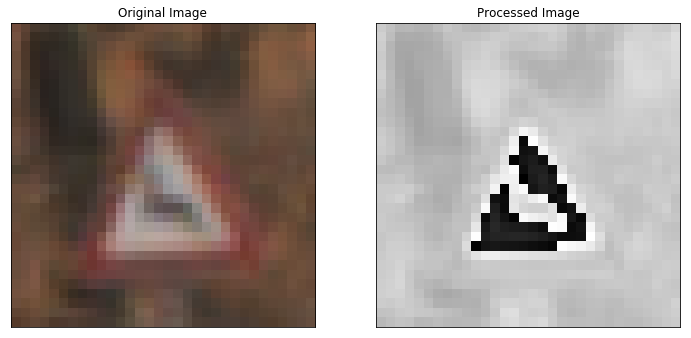

In [10]:
import cv2

example_image = X_train[300].copy()

# Convert the image from the RGB color space to the YUV color space
example_bw_image = cv2.cvtColor(example_image, cv2.COLOR_RGB2YUV)

# Extract only data in the Y channel
example_bw_image = example_bw_image[:,:,0]

# Normalize the image using the formula (x - 128) / 128
normalized = (example_bw_image - 128) / 128

# Plot the unaltered example image
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(example_image)
plt.title('Original Image')
plt.grid(True)
plt.xticks([])
plt.yticks([])


# Plot the image with Gaussian blur
plt.subplot(1,2,2)
plt.imshow(normalized, cmap='gray')
plt.title('Processed Image')
plt.xticks([])
plt.yticks([])

plt.show()

That normalizing formula ($\frac{x-128}{128}$) clearly won't work. Whereas one might be able to discern the sign in the original image, it is difficult to identify the sign in the processed image.

Let's try using another function. The `cv2.equalizeHist` function looks promising, as does the `cv2.normalize` function. Let's compare the two.

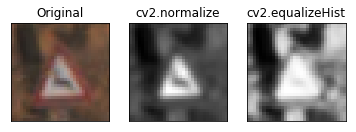

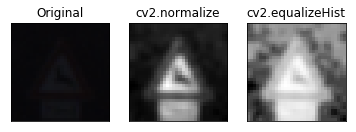

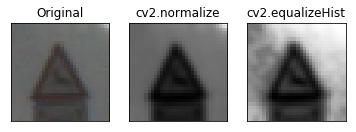

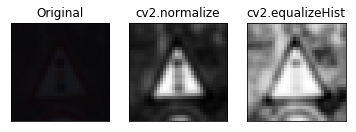

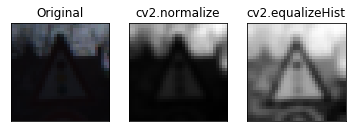

In [143]:
for ind in [300, 330, 457, 1545, 1551]:
    example_image = X_train[ind].copy()

    # Convert the image from the RGB color space to the YUV color space
    example_bw_image = cv2.cvtColor(example_image, cv2.COLOR_RGB2YUV)

    # Extract data only in the Y channel
    example_bw_image = example_bw_image[:,:,0]

    # Normalize the image using the normalize() function in the cv2 module
    normalized = np.zeros((32,32))
    normalized = cv2.normalize(example_bw_image,  normalized, 0, 255, cv2.NORM_MINMAX)

    # Add a small amount of Gaussian Blur
    example_bw_image_blurred = cv2.GaussianBlur(normalized, (3,3), 1)
    
    # Perform histogram equalization
    example_bw_histEq = cv2.equalizeHist(example_bw_image)
    example_bw_histEq = cv2.GaussianBlur(example_bw_histEq, (3,3), 1)

    # Plot the unaltered example image
    plt.subplot(1,3,1)
    plt.imshow(example_image)
    plt.title('Original')
    plt.grid(True)
    plt.xticks([])
    plt.yticks([])


    # Plot the image with Gaussian blur
    plt.subplot(1,3,2)
    plt.imshow(example_bw_image_blurred, cmap='gray')
    plt.title('cv2.normalize')
    plt.xticks([])
    plt.yticks([])
    
    # Plot the image with histogram equalization
    plt.subplot(1,3,3)
    plt.imshow(example_bw_histEq, cmap='gray')
    plt.title('cv2.equalizeHist')
    plt.xticks([])
    plt.yticks([])

    plt.show()

Regardless of the method, the images consistently look better with some sort of normalization. In some cases, the image looks better when cv2.normalize() is used whereas in other cases, the image looks better when cv2.equalizeHist is used. The choice of one over another is not clear. It seems that cv2.normalize is the safer option, though.

Let's explore the blur that we added.

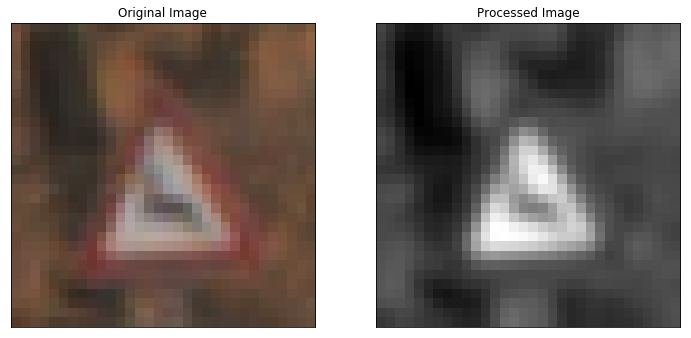

In [157]:

example_image = X_train[300].copy()

# Convert the image from the RGB color space to the YUV color space
example_bw_image = cv2.cvtColor(example_image, cv2.COLOR_RGB2YUV)

# Extract only data in the Y channel
example_bw_image = example_bw_image[:,:,0]

# Normalize the image using the normalize() function in the cv2 module
normalized = np.zeros((32,32))
normalized = cv2.normalize(example_bw_image,  normalized, 0, 255, cv2.NORM_MINMAX)

# Add a small amount of Gaussian Blur
example_bw_image_blurred = cv2.GaussianBlur(normalized, (3,3), 1)

# Plot the unaltered example image
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(example_image)
plt.title('Original Image')
plt.grid(True)
plt.xticks([])
plt.yticks([])


# Plot the image with Gaussian blur
plt.subplot(1,2,2)
plt.imshow(example_bw_image_blurred, cmap='gray')
plt.title('Processed Image')
plt.xticks([])
plt.yticks([])

plt.show()

The blurring appears not to have a positive effect. It is difficult to decide, however, if this tradeoff is greater than the benefit of reduced potential noise. This decision must be evaluated with further information. We will retain the method for now but may have to further consider this down the line.

Our modifications thus far look decent. Let's try this on a larger set of images to make sure.

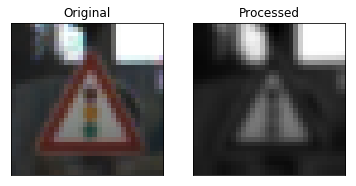

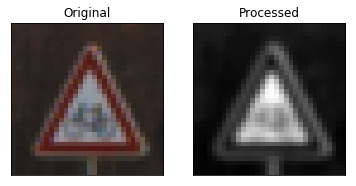

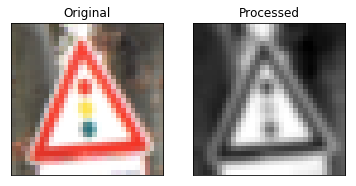

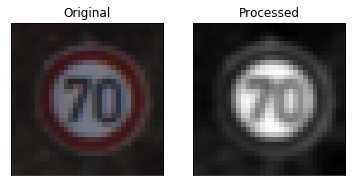

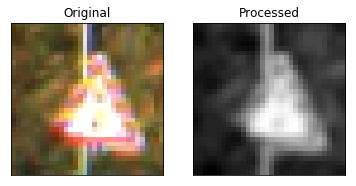

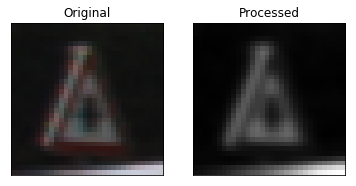

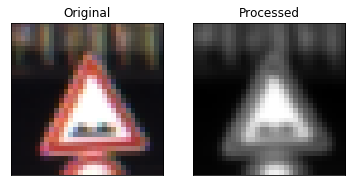

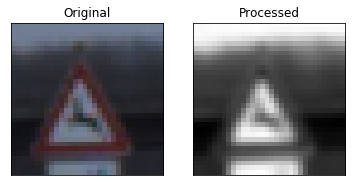

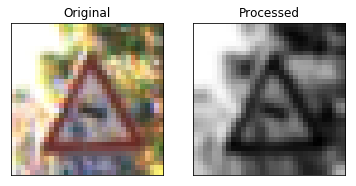

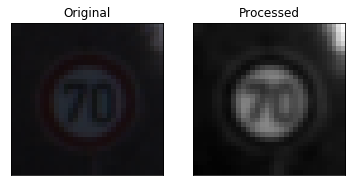

In [146]:
plt.figure(figsize=(6,3))
for i in range(1,21,2):    
    example_image = X_train[np.random.randint(0,n_test)].copy()

    # Convert the image from the RGB color space to the YUV color space
    example_bw_image = cv2.cvtColor(example_image, cv2.COLOR_RGB2YUV)

    # Extract data only in the Y channel
    example_bw_image = example_bw_image[:,:,0]

    # Normalize the image using the normalize() function in the cv2 module
    normalized = np.zeros((32,32))
    normalized = cv2.normalize(example_bw_image,  normalized, 0, 255, cv2.NORM_MINMAX)
    
    # Add a small amount of Gaussian Blur
    example_bw_image_blurred = cv2.GaussianBlur(normalized, (3,3), 1)

    # Plot the unaltered example image
    plt.subplot(1,2,1)
    plt.imshow(example_image)
    plt.title('Original')
    plt.grid(True)
    plt.xticks([])
    plt.yticks([])


    # Plot the image with Gaussian blur
    plt.subplot(1,2,2)
    plt.imshow(example_bw_image_blurred, cmap='gray')
    plt.title('Processed')
    plt.xticks([])
    plt.yticks([])

    plt.show()

Let's also try jittering our images. Sermanet and LeCun (2011) claim that doing so to augment the training dataset resulted in significantly better performance. Specifically, the paper mentioned alterations "in position ([-2, 2] pixels), in scale ([.9, 1.1] ratio), and rotation ([-15, +15] degrees)." We'll not try to emulate their exact actions.

Let us begin with an attempt to add random noise.

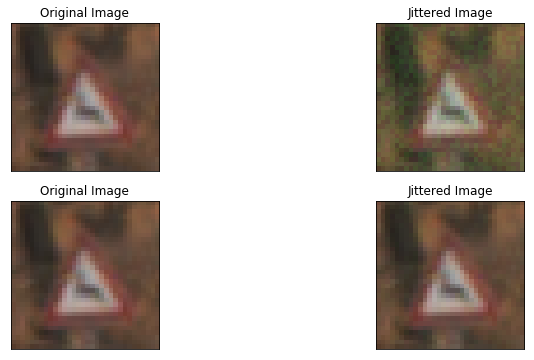

In [306]:
def addNoise(img, amount):
    l, w, d = img.shape

    # Limiting noise so much seems harsh, but the classifier stayed at around 0.056-0.059%
    #  accuracy on the training set and 0.40-0.50% accuracy on the validation set for
    #  several epochs even when the upper bound for noise was anywhere from 1 to 10, or
    #  more.This is slightly better than chance (approximately 2/43 as opposed to 1/43),
    #  but no improvement was seen after over a number of epochs in each case.
    noise = np.random.randint(0, amount, (l,w))
    jitter = np.zeros_like(img)
    jitter[:,:,1] = noise

    processed_img = cv2.add(img, jitter)
    
    return processed_img

orig_img = X_train[300].copy()

processed_img = addNoise(orig_img, 25)

plt.figure(figsize=(12,6))
plt.subplot(2,2,1)
plt.imshow(orig_img)
plt.title('Original Image')
plt.xticks([])
plt.yticks([])

# Plot the altered image
plt.subplot(2,2,2)
plt.imshow(processed_img)
plt.title('Jittered Image')
plt.xticks([])
plt.yticks([])

processed_img = addNoise(orig_img, 5)

plt.subplot(2,2,3)
plt.imshow(orig_img)
plt.title('Original Image')
plt.xticks([])
plt.yticks([])

# Plot the altered image
plt.subplot(2,2,4)
plt.imshow(processed_img)
plt.title('Jittered Image')
plt.xticks([])
plt.yticks([])

plt.show()


Looks decent. It's noisy enough that we appear to have a different image, but not to such an extent that we have a different sign.

Now let's try shifting the position of the image. I presume that what they mean is shifting the image in a certain direction and padding the vacated space with fluff (e.g., 0's).

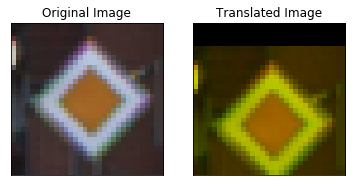

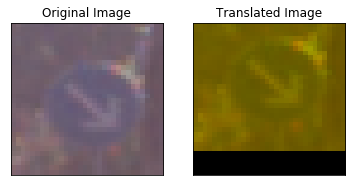

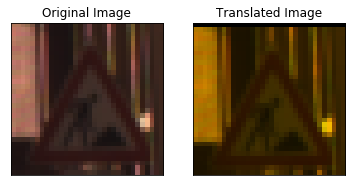

In [631]:
def alterPos(img):
    altered = np.zeros_like(ex)
    
    direction = np.random.randint(1,5)
    amt = np.random.randint(1,6)

    # There is no block that begins with 'if direction == 0:' because
    #  we always want some degree of alteration
    if direction == 1:
        for i in range(2):
            altered[amt:,:,i] = img[:32-amt,:,i]
    elif direction == 2:
        for i in range(2):
            altered[:32-amt,:,i] = img[amt:,:,i]
    elif direction == 3:
        for i in range(2):
            altered[:,amt:,i] = img[:,:32-amt,i]
    elif direction == 4:
        for i in range(2):
            altered[:,:32-amt,i] = img[:,amt:,i]
    return altered

for i in range(3):
    orig_img = X_train[np.random.randint(n_train)].copy() 
    processed_img = alterPos(orig_img)

    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plt.imshow(orig_img)
    plt.title('Original Image')
    plt.xticks([])
    plt.yticks([])

    # Plot the altered image
    plt.subplot(1,2,2)
    plt.imshow(processed_img)
    plt.title('Translated Image')
    plt.xticks([])
    plt.yticks([])

    plt.show()

Looks like it worked. The colors changed too, but since we're still dealing with the same array of numbers in numpy, I'm not concerned. Let's move on to rotation, limited to [-15, +15] degrees.

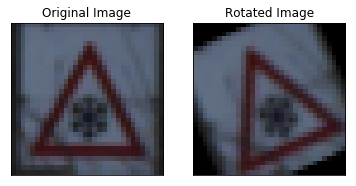

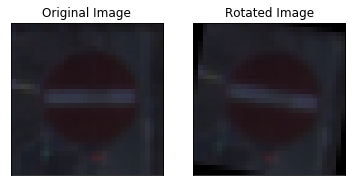

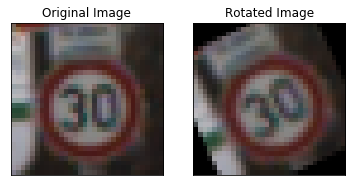

In [325]:
def rotate(img):
    (l,w) = img.shape[:2]
    center = (w/2, l/2)
    amt = np.random.uniform(low=-30, high=30)
    while not amt:
        amt = np.random.uniform(low=-30, high=30)
    rotMatrix = cv2.getRotationMatrix2D(center, amt, 1.)
    processed_img = cv2.warpAffine(img, rotMatrix, (w, l))
    return processed_img

for i in range(3):
    orig_img = X_train[np.random.randint(n_train)].copy() 
    processed_img = rotate(orig_img)

    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plt.imshow(orig_img)
    plt.title('Original Image')
    plt.xticks([])
    plt.yticks([])

    # Plot the rotated image
    plt.subplot(1,2,2)
    plt.imshow(processed_img)
    plt.title('Rotated Image')
    plt.xticks([])
    plt.yticks([])

    plt.show()

This looks reasonable. Let's now convert all images in our train set. Before, we begin, though, it'd be nice to take a look at our data

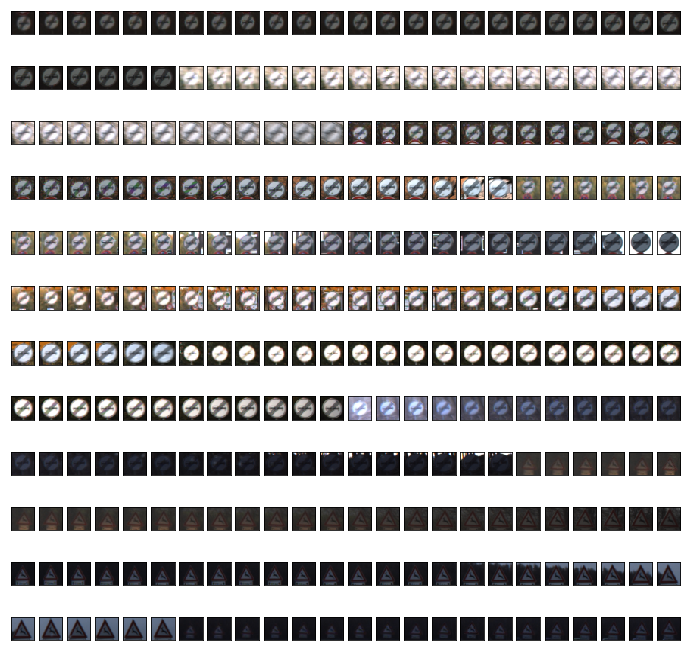

In [14]:
plt.figure(figsize=(12,12))

for i in range(288):
    plt.subplot(12, 24, i+1)
    plt.imshow(X_train[i])
    plt.xticks([])
    plt.yticks([])

Our data seems to be filled with variations of single images. All variations of each image occur before another image appears. It seems like we need to shuffle the training data.

In [15]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

Now, let's convert the entire set of training images

In [942]:
import cv2

def process_img(orig_img, alter=False):
    """
    This function takes an image, extracts data in the Y channel of the image in YUV
    color space, normalizes the image, adds Gaussian blur, then converts the shape
    of the image.
    """
    
    img = orig_img.copy()
    
    # Let's first add noise, translate, or rotate the image. We should not do this
    #  to the validation or test sets, so we must introduce a flag.
    if alter:
        processed_img = alterPos(img)
        processed_img = rotate(processed_img)
    else:
        processed_img = img
    
    # Convert to the YUV color space and extract only data in the Y channel
    processed_image = cv2.cvtColor(processed_img, cv2.COLOR_RGB2YUV)
    
    # Use normalize() in cv2 to normalize the image
    normalized = processed_image[:,:,0].copy()
    processed_image = processed_image[:,:,0]
    normalized = cv2.normalize(processed_image, normalized, 0, 255, cv2.NORM_MINMAX)
    
    # Add a small amount of Gaussian Blur
    """
    Note: it seems Gaussian Blur significantly hurts performance so we'll remove this
    processed_image = cv2.GaussianBlur(normalized, (3,3), 1)
    """
    
    # We need the shape to be (32,32,1) rather than just (32,32) and we'll also add a
    #  dimension at the front so we may use np.concatenate
    processed_image.shape = (1,) + processed_image.shape + (1,)
    return processed_image

In [1012]:
# Augment indiscriminately

X_train_bw, y_train_bw = [], []
for i in range(n_train*9):
    # Collect processed images into an array
    X_train_bw.append(process_img(X_train[i//9], True))
    y_train_bw.append(y_train[i//9])
    
for i in range(n_train):
    # Add the unaltered images to the arrays
    X_train_bw.append(process_img(X_train[i], False))
    y_train_bw.append(y_train[i])

X_train = np.concatenate(X_train_bw,axis=0)
y_train = np.array(y_train_bw)

The following enlarges the dataset in a way that ensures that each traffic sign class appears equally. Either this or the above cell may be run, but not both.

In [943]:
# We are augmenting the size of the training set so we need to create y_train appropriately
# Sermanet and Lecun (2011) enlarged the training set to be five times as large when
#  they introduced merely jitter and they still obtained a benefit. Since we have more
#  alterations in place and will try increasing the size of the set to ten times its
#  original amount.
X_train_bw, y_train_bw = [], []

# Calculate a number of alterations of each image to add to obtain equal proportions of each.
num_to_add = np.array((train_counts.max() - train_counts + 7*n_train/43), dtype=np.int32)
for i in range(n_train*45):
    if num_to_add[y_train[i//45]]:
        # Collect processed images into an array
        X_train_bw.append(process_img(X_train[i//45], True))
        y_train_bw.append(y_train[i//45])
        num_to_add[y_train[i//45]] -= 1
    
for i in range(n_train):
    # Add the unaltered images to the arrays
    X_train_bw.append(process_img(X_train[i], False))
    y_train_bw.append(y_train[i])

X_train = np.concatenate(X_train_bw,axis=0)
y_train = np.array(y_train_bw)

No matter how we dealt with the training set, we'll also have to convert the validation and test sets to greyscale (extract only data in the respective Y channel in order for the data to run through the model.

In [1013]:
X_valid_bw, X_test_bw = [], []

for i in range(X_valid.shape[0]):
    img = process_img(X_valid[i])
    X_valid_bw.append(img)
    
for i in range(X_test.shape[0]):
    img = process_img(X_test[i])
    X_test_bw.append(img)


X_valid = np.concatenate(X_valid_bw,axis=0)
X_test = np.concatenate(X_test_bw,axis=0)

Let's look at the resulting proportions to see if we did accomplished our goal of equal representation in the training set.

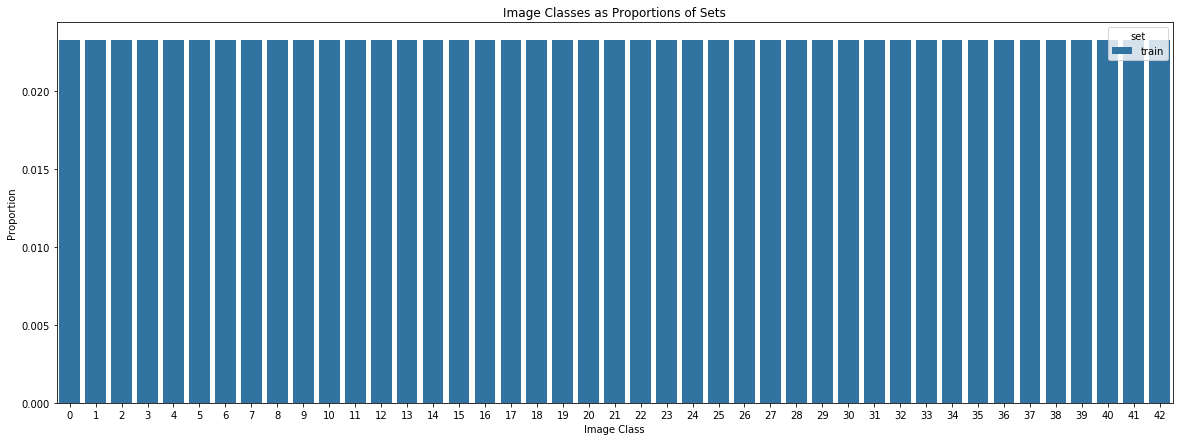

In [945]:
# Find the number of instances of each unique in each image in each dataset
_, train_counts_augmented = np.unique(y_train, return_counts=True)

# Put the data in a dataframe
# The training set is significantly larger than the other two sets so it would
#  seems advisable to look at relative frequencies instead.
train_augmented_ratios = train_counts_augmented / train_counts_augmented.sum()
counts_df = pd.DataFrame({'count' : train_augmented_ratios,
                  'type' : [i for i in range(43)], 
                  'set' : ['train']*43})

# # Draw a nested barplot to show the proportion of each set made up by each image class
plt.figure(figsize=(20,7))
sns.barplot(data=counts_df, x='type',y='count',hue='set')
plt.ylabel('Proportion')
plt.xlabel('Image Class')
plt.title('Image Classes as Proportions of Sets')
plt.show()

Looks uniform, so it seems like our attempt worked! Let's move on to designing the classifier.

<a id="design"/a>
----

## Design and Test a Model Architecture

We'll try and compare two model architectures in the following. The first is based on the [LeNet-5 architecture](http://yann.lecun.com/exdb/lenet/). We'll have three convolutional layers, each including pooling and dropout, followed by three fully connected layers, which represent the classifier.

The second is a multi-stage architecture (MS), which was found by Sermanet and LeCun ([2011](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf)) to significantly outperform a single-scale architecture. According to them, "the most successful architecture uses MS without color"

In [18]:
import tensorflow as tf

In [56]:
x = tf.placeholder(tf.float32, (None,32,32,1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y,43)

In [976]:
from tensorflow.contrib.layers import flatten

def classifier(x):
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    n_classes = 43
    
    weights = {
        'w1' : tf.Variable(tf.truncated_normal([5, 5, 1, 6], mean=mu, stddev=sigma)),
        'w2' : tf.Variable(tf.truncated_normal([5, 5, 6, 16], mean=mu, stddev=sigma)),
        'w3' : tf.Variable(tf.truncated_normal([400, 120], mean=mu, stddev=sigma)),
        'w4' : tf.Variable(tf.truncated_normal([120, 84], mean=mu, stddev=sigma)),
        'w5' : tf.Variable(tf.truncated_normal([84, n_classes], mean=mu, stddev=sigma))
    }
    
    biases = {
        'b1' : tf.Variable(tf.zeros([6])),
        'b2' : tf.Variable(tf.zeros([16])),
        'b3' : tf.Variable(tf.zeros([120])),
        'b4' : tf.Variable(tf.zeros([84])),
        'b5' : tf.Variable(tf.zeros([n_classes]))
    }
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    y1 = tf.nn.conv2d(x, weights['w1'], strides=[1,1,1,1], padding='VALID')
    y1 = tf.nn.bias_add(y1, biases['b1'])

    # Activation.
    y1 = tf.nn.relu(y1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    y1 = tf.nn.max_pool(y1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')

    # Dropout.
    y1 = tf.nn.dropout(y1, keep_prob)
    
    # Layer 2: Convolutional. Output = 10x10x16.
    y2 = tf.nn.conv2d(y1, weights['w2'], strides=[1,1,1,1], padding='VALID')
    y2 = tf.nn.bias_add(y2, biases['b2'])

    # Activation.
    y2 = tf.nn.relu(y2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    y2 = tf.nn.max_pool(y2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')

    # Dropout.
    y2 = tf.nn.dropout(y2, keep_prob)
    
    # Flatten. Input = 5x5x16. Output = 400.
    y3 = flatten(y2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    y3 = tf.add(tf.matmul(y3, weights['w3']), biases['b3'])
    
    # Activation.
    y3 = tf.nn.relu(y3)

    # Dropout.
    y3 = tf.nn.dropout(y3, keep_prob)
    
    # Layer 4: Fully Connected. Input = 120. Output = 84.
    y4 = tf.add(tf.matmul(y3, weights['w4']), biases['b4'])
    
    # Activation.
    y4 = tf.nn.relu(y4)

    # Dropout.
    y4 = tf.nn.dropout(y4, keep_prob)
    
    # Layer 5: Fully Connected. Input = 84. Output = 43.
    return tf.add(tf.matmul(y4, weights['w5']), biases['b5'])

In [226]:
rate = 0.001

logits = classifier(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [227]:
predictions = tf.argmax(logits, 1)
probabilities_operation = tf.nn.softmax(logits=logits)

In [228]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

The following shows the output of testing the first model architecture - the single stage CNN.

In [995]:
from time import time

EPOCHS = 25
BATCH_SIZE = 128
PROB = 0.73

accuracies = []

with tf.Session() as sess:
    with open('ss-cnn-log-{}.txt'.format(PROB), 'w') as f:
        sess.run(tf.global_variables_initializer())
        num_examples = len(X_train)

        f.write("Training...")
        f.write('\n')
        prev_time = time()
        for i in range(EPOCHS):
            X_train, y_train = shuffle(X_train, y_train)
            for offset in range(0, num_examples, BATCH_SIZE):
                end = offset + BATCH_SIZE
                batch_x, batch_y = X_train[offset:end], y_train[offset:end]
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: PROB})

            f.write("EPOCH {} (approximate seconds required: {:.1f})".format(i+1, time() - prev_time))
            prev_time = time()

            training_accuracy = evaluate(X_train, y_train)
            validation_accuracy = evaluate(X_valid, y_valid)
            accuracies.append([i+1, training_accuracy, validation_accuracy])
            f.write("  Training Accuracy = {:.3f}".format(training_accuracy))
            f.write("  Validation Accuracy = {:.3f}".format(validation_accuracy))
        f.write('  Test accuracy: {}'.format(evaluate(X_test,y_test)))
        f.write('\n')


        saver.save(sess, './saved_models/tsc')
        f.write("Model saved")

In [788]:
saved_accuracies = np.array(accuracies).copy()

Initial training suggests that it is possible that the model may be overtraining on some images. The model does extremely well on the training and validation sets, but nowhere near as well on the test set. Let's see what happens when we augment the training set even more. We'll also increase the amount by which positions may change.

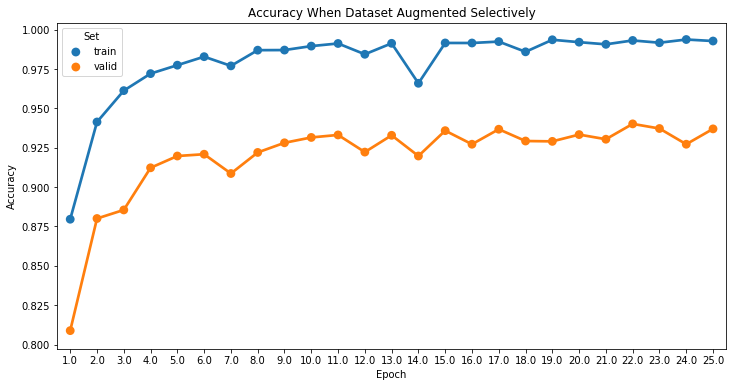

In [573]:
# Num training examples: 121217
accuracy_df = pd.DataFrame({'Epoch' : np.concatenate([saved_accuracies[:,0],saved_accuracies[:,0]]),
                            'Accuracy' : np.concatenate([saved_accuracies[:,1], saved_accuracies[:,2]]),
                            'Set' : ['train'] * 25 + ['valid'] * 25})
plt.figure(figsize=(12,6))
sns.pointplot(data=accuracy_df, x='Epoch', y='Accuracy', hue='Set')
plt.title('Accuracy When Dataset Augmented Selectively')
plt.show()

It seems that we have a greater separation between the training and validation accuracies and the validation accuracy is more reflective of the final test accuracy. However, our model is still overfitting the given data. It is notable that our training set size is, in this case, almost three times smaller. The performance improves slightly if we augment the training set in that accuracy on the validation set is closer to accuracy on the training set. However, the change in performance is not inspiring. We'll move on to a different model architecture.

The next model architecture is based on that described by Sermanet and LeCun ([2011](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf)). We'll also, in addition, introduce regularization, in the form of dropout, and show the results of different hyperparameters.

Traditionally, convolutional neural nets are typically composed of 1-3 stages, which are followed by a classifier composed of 1-2 layers. Specifically, we'll implement a 2-stage convolutional neural network architecture, in which we have:
* 2 stages: the input is convolved and subsampled twice in the first stage. The results are:
  * Fed directly to the classifier and
  * Sent to a second stage in which the results are convolved again. The further results are also sent to the classifier. In this way, the classifier is fed input as a concatenation of two sets of results
* The classifier is composed of 2 fully connected layers.

A 2-stage ConvNet architecture. The input is processed in a feedforward
manner through two stage of convolutions and subsampling, and
finally classified with a linear classifier. The output of the 1st stage is also
fed directly to the classifier as higher-resolution features.

In [951]:
from tensorflow.contrib.layers import flatten

def classifier(x):
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    n_classes = 43
    
    weights = {
        'w1' : tf.Variable(tf.truncated_normal([5, 5, 1, 6], mean=mu, stddev=sigma)),
        'w2' : tf.Variable(tf.truncated_normal([5, 5, 6, 16], mean=mu, stddev=sigma)),
        'w3' : tf.Variable(tf.truncated_normal([5, 5, 16, 16], mean=mu, stddev=sigma)),
        'w4' : tf.Variable(tf.truncated_normal([800, 400], mean=mu, stddev=sigma)),
        'w5' : tf.Variable(tf.truncated_normal([400, 120], mean=mu, stddev=sigma)),
        'w6' : tf.Variable(tf.truncated_normal([120, n_classes], mean=mu, stddev=sigma))
    }
    
    biases = {
        'b1' : tf.Variable(tf.zeros([6])),
        'b2' : tf.Variable(tf.zeros([16])),
        'b3' : tf.Variable(tf.zeros([16])),
        'b4' : tf.Variable(tf.zeros([400])),
        'b4' : tf.Variable(tf.zeros([120])),
        'b5' : tf.Variable(tf.zeros([n_classes]))
    }
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    layer1 = tf.nn.conv2d(x, weights['w1'], strides=[1,1,1,1], padding='VALID')
    layer1 = tf.nn.bias_add(y1, biases['b1'])

    # Activation.
    y1 = tf.nn.relu(layer1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    y1 = tf.nn.max_pool(y1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    y2 = tf.nn.dropout(y1, keep_prob)
    y2 = tf.nn.conv2d(y1, weights['w2'], strides=[1,1,1,1], padding='VALID')
    y2 = tf.nn.bias_add(y2, biases['b2'])

    # Activation.
    y2 = tf.nn.relu(y2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    y2 = tf.nn.max_pool(y2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    
    # Dropout.
    y2 = tf.nn.dropout(y2, keep_prob)
    
    # Flatten. Input = 5x5x16. Output = 400
    stage1 = flatten(y2)
    
    # Layer 3: Convolutional. Input = 5x5x16. Output = 5x5x16
    y3 = tf.nn.conv2d(y2, weights['w3'], strides=[1,1,1,1], padding='VALID')
    y3 = tf.nn.bias_add(y3, biases['b3'])
    
    # Activation
    y3 = tf.nn.relu(y3)
    
    # Dropout.
    y3 = tf.nn.dropout(y3, keep_prob)
    
    # Flatten. Input = 5x5x16. Output = 400.
    stage2 = flatten(y3)
    
    # Layer 4: Fully Connected. Input = 800. Output = 400.
    fc_input = tf.concat_v2([stage1, stage2], axis=1)
    y4 = tf.add(tf.matmul(fc_input, weights['w4']), biases['b3'])
    
    # Activation.
    y4 = tf.nn.relu(y4)

    # Dropout.
    y4 = tf.nn.dropout(y4, keep_prob)
    
    # Layer 5: Fully Connected. Input = 400. Output = 120.
    y5 = tf.add(tf.matmul(y4, weights['w5']), biases['b4'])
    
    # Activation.
    y5 = tf.nn.relu(y5)

    # Dropout.
    y5 = tf.nn.dropout(y5, keep_prob)
    
    # Layer 6: Fully Connected. Input = 120. Output = 43.
    return tf.add(tf.matmul(y5, weights['w6']), biases['b5'])

The following shows the output of training the second model architecture - the multi-stage CNN.

In [1035]:
EPOCHS = 50
BATCH_SIZE = 128
PROB = 0.61

accuracies = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    prev_time = time()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: PROB})
            
        print("EPOCH {} (approximate seconds required: {:.1f})".format(i+1, time() - prev_time))
        prev_time = time()
        
        training_accuracy = evaluate(X_train, y_train)
        validation_accuracy = evaluate(X_valid, y_valid)
        accuracies.append([i+1, training_accuracy, validation_accuracy])
        print("  Training Accuracy = {:.3f}".format(training_accuracy))
        print("  Validation Accuracy = {:.3f}".format(validation_accuracy))
    print('  Test accuracy: {}'.format(evaluate(X_test,y_test)))
    print()

    
    saver.save(sess, './saved_models/MS/tsc')
    print("Model saved")

Training...

EPOCH 1 (approximate seconds required: 104.8)
  Training Accuracy = 0.547
  Validation Accuracy = 0.655
EPOCH 2 (approximate seconds required: 149.9)
  Training Accuracy = 0.678
  Validation Accuracy = 0.773
EPOCH 3 (approximate seconds required: 152.6)
  Training Accuracy = 0.737
  Validation Accuracy = 0.777
EPOCH 4 (approximate seconds required: 152.9)
  Training Accuracy = 0.764
  Validation Accuracy = 0.809
EPOCH 5 (approximate seconds required: 153.6)
  Training Accuracy = 0.781
  Validation Accuracy = 0.847
EPOCH 6 (approximate seconds required: 153.9)
  Training Accuracy = 0.802
  Validation Accuracy = 0.825
EPOCH 7 (approximate seconds required: 154.1)
  Training Accuracy = 0.818
  Validation Accuracy = 0.846
EPOCH 8 (approximate seconds required: 154.1)
  Training Accuracy = 0.819
  Validation Accuracy = 0.849
EPOCH 9 (approximate seconds required: 154.2)
  Training Accuracy = 0.829
  Validation Accuracy = 0.855
EPOCH 10 (approximate seconds required: 154.2)
  Tr

In [1060]:
EPOCHS = 25
BATCH_SIZE = 128
PROB = 0.73

accuracies = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    prev_time = time()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: PROB})
            
        print("EPOCH {} (approximate seconds required: {:.1f})".format(i+1, time() - prev_time))
        prev_time = time()
        
        training_accuracy = evaluate(X_train, y_train)
        validation_accuracy = evaluate(X_valid, y_valid)
        accuracies.append([i+1, training_accuracy, validation_accuracy])
        print("  Training Accuracy = {:.3f}".format(training_accuracy))
        print("  Validation Accuracy = {:.3f}".format(validation_accuracy))
    print('  Test accuracy: {}'.format(evaluate(X_test,y_test)))
    print()

    
    saver.save(sess, './saved_models/MS/75/tsc')
    print("Model saved")

Training...

EPOCH 1 (approximate seconds required: 114.2)
  Training Accuracy = 0.681
  Validation Accuracy = 0.769
EPOCH 2 (approximate seconds required: 172.5)
  Training Accuracy = 0.831
  Validation Accuracy = 0.853
EPOCH 3 (approximate seconds required: 168.0)
  Training Accuracy = 0.882
  Validation Accuracy = 0.884
EPOCH 4 (approximate seconds required: 171.0)
  Training Accuracy = 0.907
  Validation Accuracy = 0.908
EPOCH 5 (approximate seconds required: 169.8)
  Training Accuracy = 0.927
  Validation Accuracy = 0.928
EPOCH 6 (approximate seconds required: 165.7)
  Training Accuracy = 0.930
  Validation Accuracy = 0.924
EPOCH 7 (approximate seconds required: 159.4)
  Training Accuracy = 0.940
  Validation Accuracy = 0.923
EPOCH 8 (approximate seconds required: 159.2)
  Training Accuracy = 0.941
  Validation Accuracy = 0.931
EPOCH 9 (approximate seconds required: 159.9)
  Training Accuracy = 0.941
  Validation Accuracy = 0.932
EPOCH 10 (approximate seconds required: 168.2)
  Tr

It seems notable that the validation accuracy consistently exceeded the training accuracy. With such a low value for `keep_prob`, we are using a higher amount of regularization so the model cannot overfit the training data. The model is learning to tune other weight parameters (e.g., those that are not "dropped") so as to minimize loss (i.e., incorrect predictions).

It is curious that the test accuracy is significantly lower than both the training and validation accuracies. The fact that the test accuracy is lower than the training accuracy suggests overfitting training data, but the fact that the validation accuracy is greater than thest test accuracy suggests that we are not overfitting training data. Perhaps the test data is significantly different from both the training and validation data.

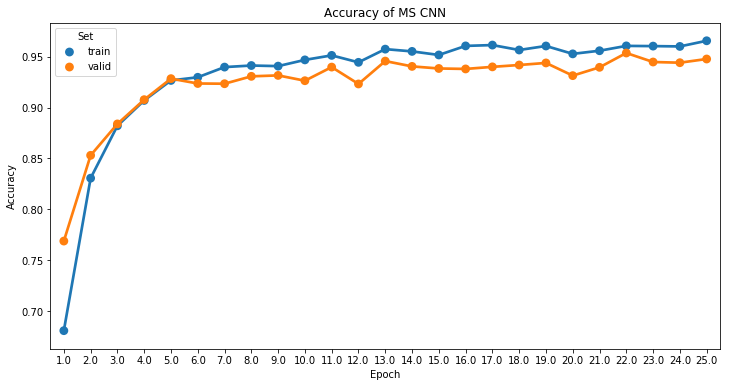

In [1074]:
ms_accuracies = np.array(accuracies).copy()
# Num training examples: 347990

accuracy_df = pd.DataFrame({'Epoch' : np.concatenate([ms_accuracies[:,0],ms_accuracies[:,0]]),
                            'Accuracy' : np.concatenate([ms_accuracies[:,1], ms_accuracies[:,2]]),
                            'Set' : ['train'] * 25 + ['valid'] * 25})
plt.figure(figsize=(12,6))
sns.pointplot(data=accuracy_df, x='Epoch', y='Accuracy', hue='Set')
plt.title('Accuracy of MS CNN')
plt.show()

It appears that after 12 epochs, we begin overfitting the training data to a slight degree. Let's create and save a model trained for only 12 epochs.

In [1092]:
EPOCHS = 12
BATCH_SIZE = 128
PROB = 0.75

accuracies = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    prev_time = time()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: PROB})
            
        print("EPOCH {} (approximate seconds required: {:.1f})".format(i+1, time() - prev_time))
        prev_time = time()
        
        training_accuracy = evaluate(X_train, y_train)
        validation_accuracy = evaluate(X_valid, y_valid)
        accuracies.append([i+1, training_accuracy, validation_accuracy])
        print("  Training Accuracy = {:.3f}".format(training_accuracy))
        print("  Validation Accuracy = {:.3f}".format(validation_accuracy))
    print('  Test accuracy: {}'.format(evaluate(X_test,y_test)))
    print()

    
    saver.save(sess, './saved_models/MS/75/2/tsc')
    print("Model saved")

Training...

EPOCH 1 (approximate seconds required: 106.6)
  Training Accuracy = 0.749
  Validation Accuracy = 0.797
EPOCH 2 (approximate seconds required: 162.3)
  Training Accuracy = 0.869
  Validation Accuracy = 0.889
EPOCH 3 (approximate seconds required: 173.3)
  Training Accuracy = 0.913
  Validation Accuracy = 0.913
EPOCH 4 (approximate seconds required: 188.5)
  Training Accuracy = 0.928
  Validation Accuracy = 0.933
EPOCH 5 (approximate seconds required: 197.7)
  Training Accuracy = 0.933
  Validation Accuracy = 0.935
EPOCH 6 (approximate seconds required: 174.3)
  Training Accuracy = 0.926
  Validation Accuracy = 0.931
EPOCH 7 (approximate seconds required: 172.9)
  Training Accuracy = 0.943
  Validation Accuracy = 0.924
EPOCH 8 (approximate seconds required: 181.8)
  Training Accuracy = 0.950
  Validation Accuracy = 0.935
EPOCH 9 (approximate seconds required: 182.8)
  Training Accuracy = 0.947
  Validation Accuracy = 0.937
EPOCH 10 (approximate seconds required: 180.2)
  Tr

Wonderful. The training and test accuracies are still near enough that it doesn't seem like we've been overfitting. In addition, the test accuracy is nice, but let us see how well our models do on new images.

<a id='predict'/>
---

## Test the Model on New Images

The images of German traffic signs used in this section were obtained from [bicyclegermany.com](bicyclegermany.com) and [gettyimages.com](http://www.gettyimages.com/)..

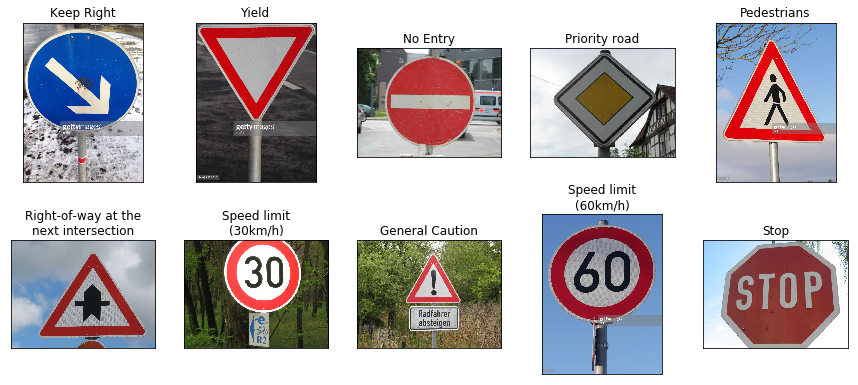

In [1102]:
imgList = os.listdir('./sign_images')
sign_types = ['Keep Right',
              'Yield',
              'No Entry',
              'Priority Road',
              'Pedestrians',
              'Right-of-way at the next intersection',
              'Speed limit (30km/h)',
              'General caution',
              'Speed limit (60km/h)',
              'Stop']
printed_types = ['Keep Right',
                 'Yield',
                 'No Entry',
                 'Priority road',
                 'Pedestrians',
                 'Right-of-way at the\nnext intersection',
                 'Speed limit\n(30km/h)',
                 'General Caution',
                 'Speed limit\n(60km/h)',
                 'Stop']
novel_labels = [38, 13, 17, 12, 27, 11, 1, 18, 3, 14]
novel_images = []
plt.figure(figsize=(15,10))
for i in range(len(novel_labels)):
    img = cv2.imread('./sign_images/' + imgList[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    novel_images.append(img)
    plt.subplot(3,len(novel_labels)//2,i+1)
    sign_type = printed_types[i]
    plt.title(sign_type)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    
plt.show()

In [1103]:
for img in novel_images:
    print(img.shape)

(479, 358, 3)
(478, 359, 3)
(480, 640, 3)
(480, 640, 3)
(1024, 768, 3)
(750, 1000, 3)
(360, 480, 3)
(480, 640, 3)
(1024, 768, 3)
(480, 640, 3)


Notice our array sizes here. The second dimension is consistently larger than the first, so we saw rectangular images in the above cell. We'll have to convert our image dimensions to 32 pixels by 32 pixels so that rectangular appearance should change if we successfully resize the images.

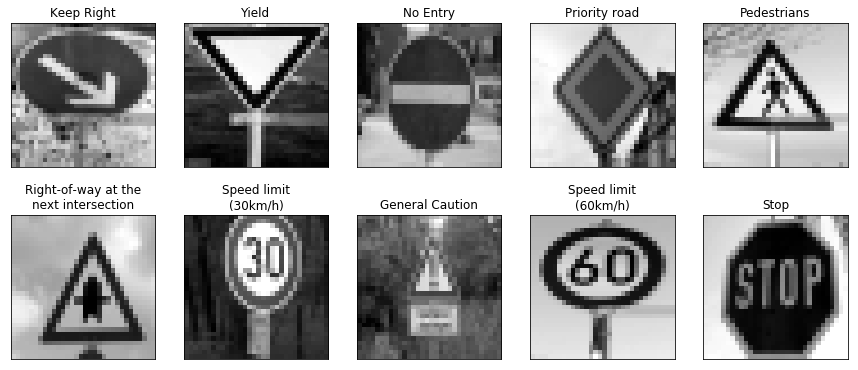

In [1104]:
dim = (32, 32)
novel_images_resized = []
plt.figure(figsize=(15,10))

# Resize images to 32x32, convert to the YUV color space, extract only
#  data in the Y channel, and store in a new array
for i in range(len(novel_labels)):
    img = novel_images[i]
    resized = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
    resized = cv2.cvtColor(resized, cv2.COLOR_RGB2YUV)[:,:,0]
    
    plt.subplot(3,len(novel_labels)//2,i+1)
    sign_type = printed_types[i]
    plt.title(sign_type)
    plt.imshow(resized, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
    resized.shape = resized.shape + (1,)
    novel_images_resized.append(resized)

plt.show()

Notice that are images are now square in shape. Their dimensions are now 32 pixels by 32 and the square appearance shows us that the resizing was as expected.

In [792]:
signnames = pd.read_csv('./signnames.csv')
signnames.set_index('ClassId', inplace=True)

### Analyze Performance

Let's see how well our models do on these new images

In [1105]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./saved_models'))
    probabilities = sess.run(probabilities_operation, 
                             feed_dict={x: np.array(
                                 novel_images_resized), keep_prob: 1})
    preds = []
    for probs in probabilities:
        preds.append(np.argmax(probs))
    accuracy_on_novel_images = sum(
        np.array(preds) == np.array(novel_labels)) / len(preds)

In [1106]:
# (Single-scale CNN)
with tf.Session() as sess:
    print('(With training set augmented indiscriminately)')
    print('Accuracy For Novel Images: {:.0f}%'.format(100 * accuracy_on_novel_images))

(With training set augmented indiscriminately)
Accuracy For Novel Images: 70%


In [1111]:
# Multi-scale CNN
with tf.Session() as sess:
    print('(Multi-scale CNN)')
    print('Accuracy For Novel Images: {:.0f}%'.format(100 * accuracy_on_novel_images))

(Multi-scale CNN)
Accuracy For Novel Images: 90%


This is lower than the results of training would suggest. It seems that not only did we overtrain on the training data such that the model did not generalize as well when given the test data set, our model also generalized terribly to data provided by a different entity.

<a id='probabilities'/>
---

## Analyze the softmax probabilities of predictions on the new images

Let's look more closely at the predictions that were made. Since we don't want 43 sets of predictions for each sign, most of which are 0 and uninformative, we'll limit our analyses to the top five predictions made for each image.

In [1108]:
probs = probabilities[0]
top_5_probs_values, top_5_probs_indices = [], []
with tf.Session() as sess:
    for probs in probabilities:
        vals, indices = sess.run(tf.nn.top_k(tf.constant(probs), k=5))
        top_5_probs_values.append(vals)
        top_5_probs_indices.append(indices)

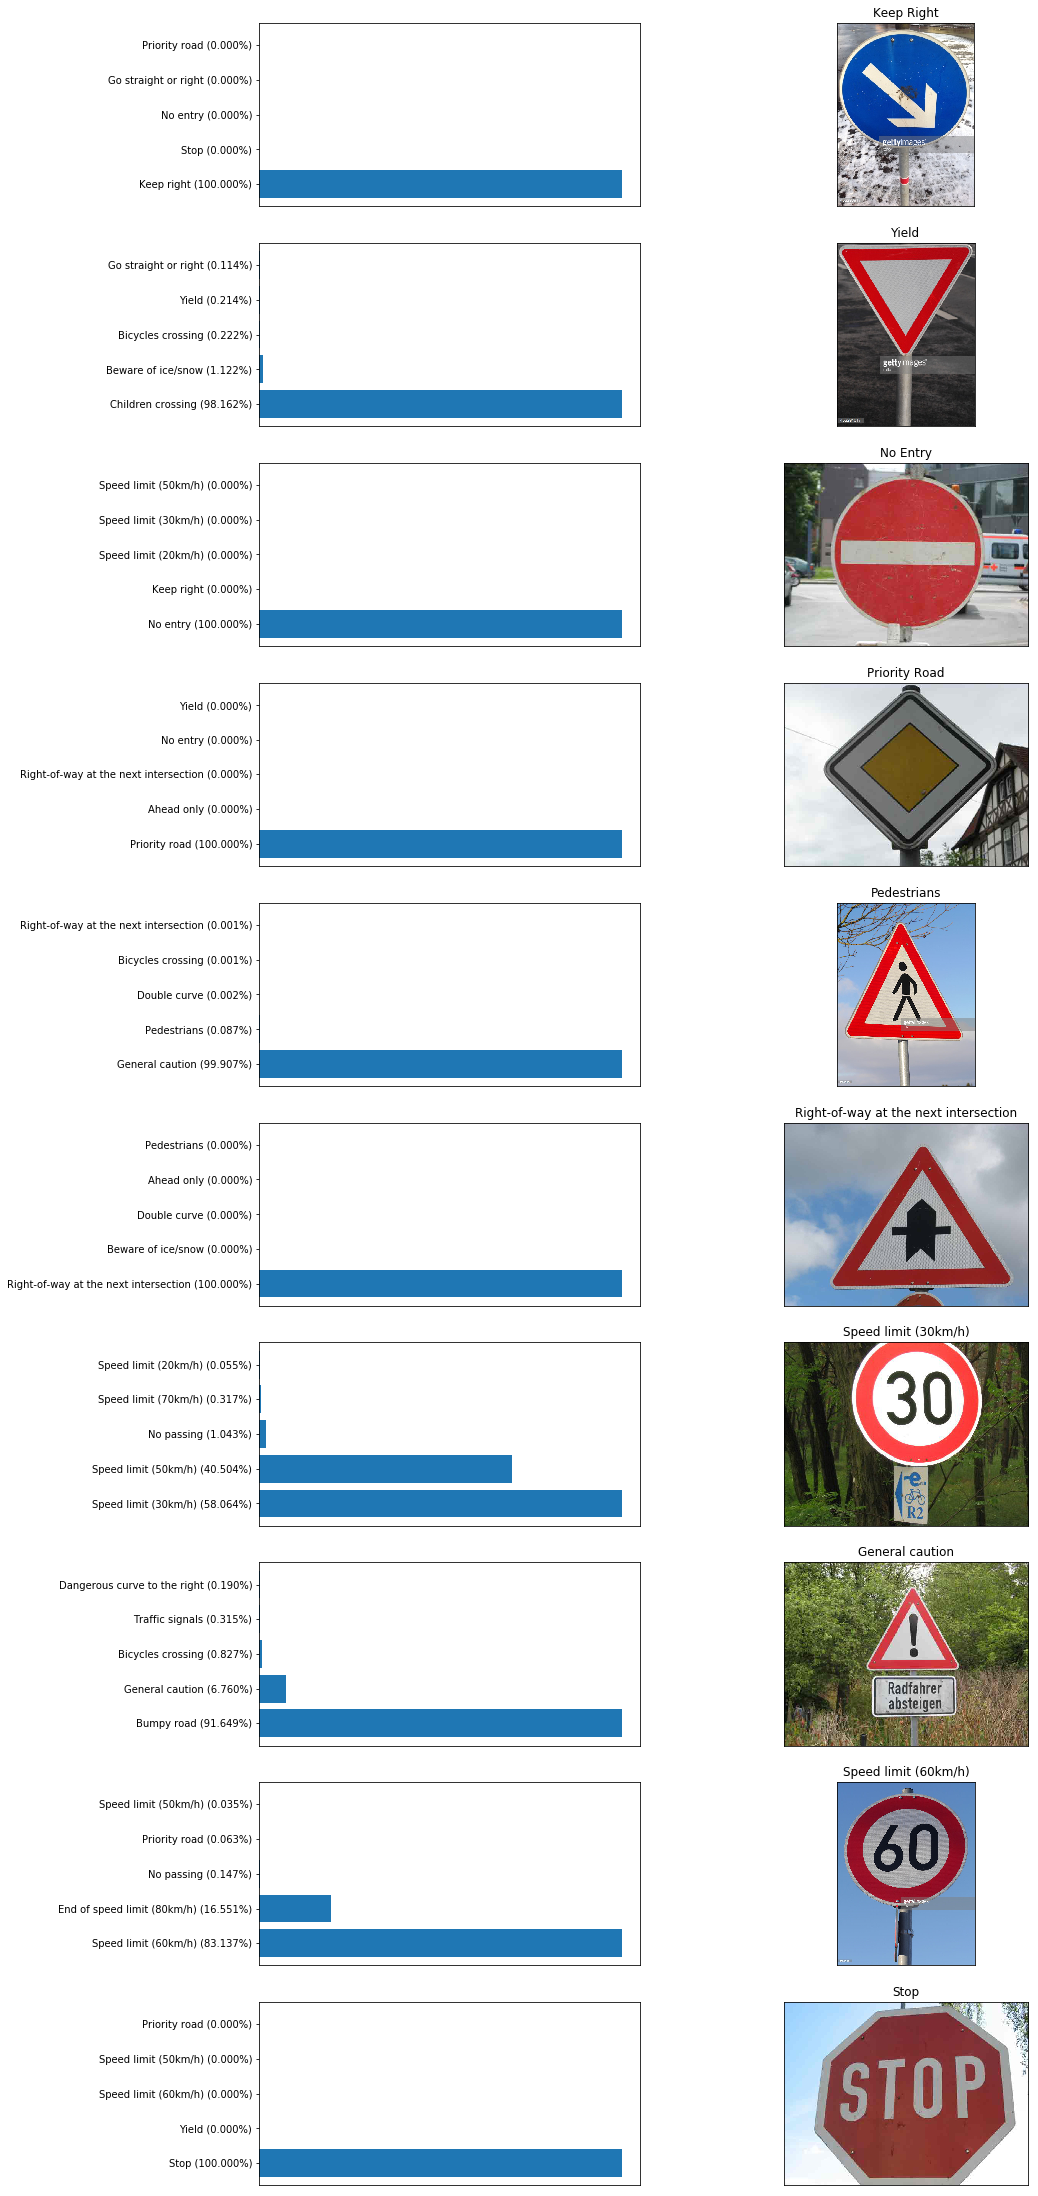

In [1109]:
# Predictions of single-scale CNN

plt.figure(figsize=(15, 60))
for i in range(len(novel_labels)):
    plt.subplot(15, 2, (2*i)+2)
    plt.imshow(novel_images[i]) 
    plt.title(sign_types[i])
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(15, 2, (2*i)+1)
    prob = top_5_probs_values[i]
    ind = top_5_probs_indices[i]
    plt.xticks([])
    plt.yticks([])
    plt.barh([j+1 for j in range(5)], prob)
    ytick_labels = []
    for sign_ind, sign_prob in zip(ind, prob):
        ytick_labels.append('{} ({:.3f}%)'.format(
            signnames.iloc[sign_ind]['SignName'],
            sign_prob * 100))
    plt.yticks([j+1 for j in range(5)], 
               ytick_labels)
plt.show()

In [1110]:
# Predictions of multi-scale CNN
'''
'''

with tf.Session() as sess:
#     saver2 = tf.train.import_meta_graph('./saved_models/MS/75')
    saver.restore(sess, tf.train.latest_checkpoint('./saved_models/MS/75/2'))
    probabilities = sess.run(probabilities_operation, 
                             feed_dict={x: np.array(
                                 novel_images_resized), keep_prob: 1})
    preds = []
    for probs in probabilities:
        preds.append(np.argmax(probs))
    accuracy_on_novel_images = sum(
        np.array(preds) == np.array(novel_labels)) / len(preds)
    

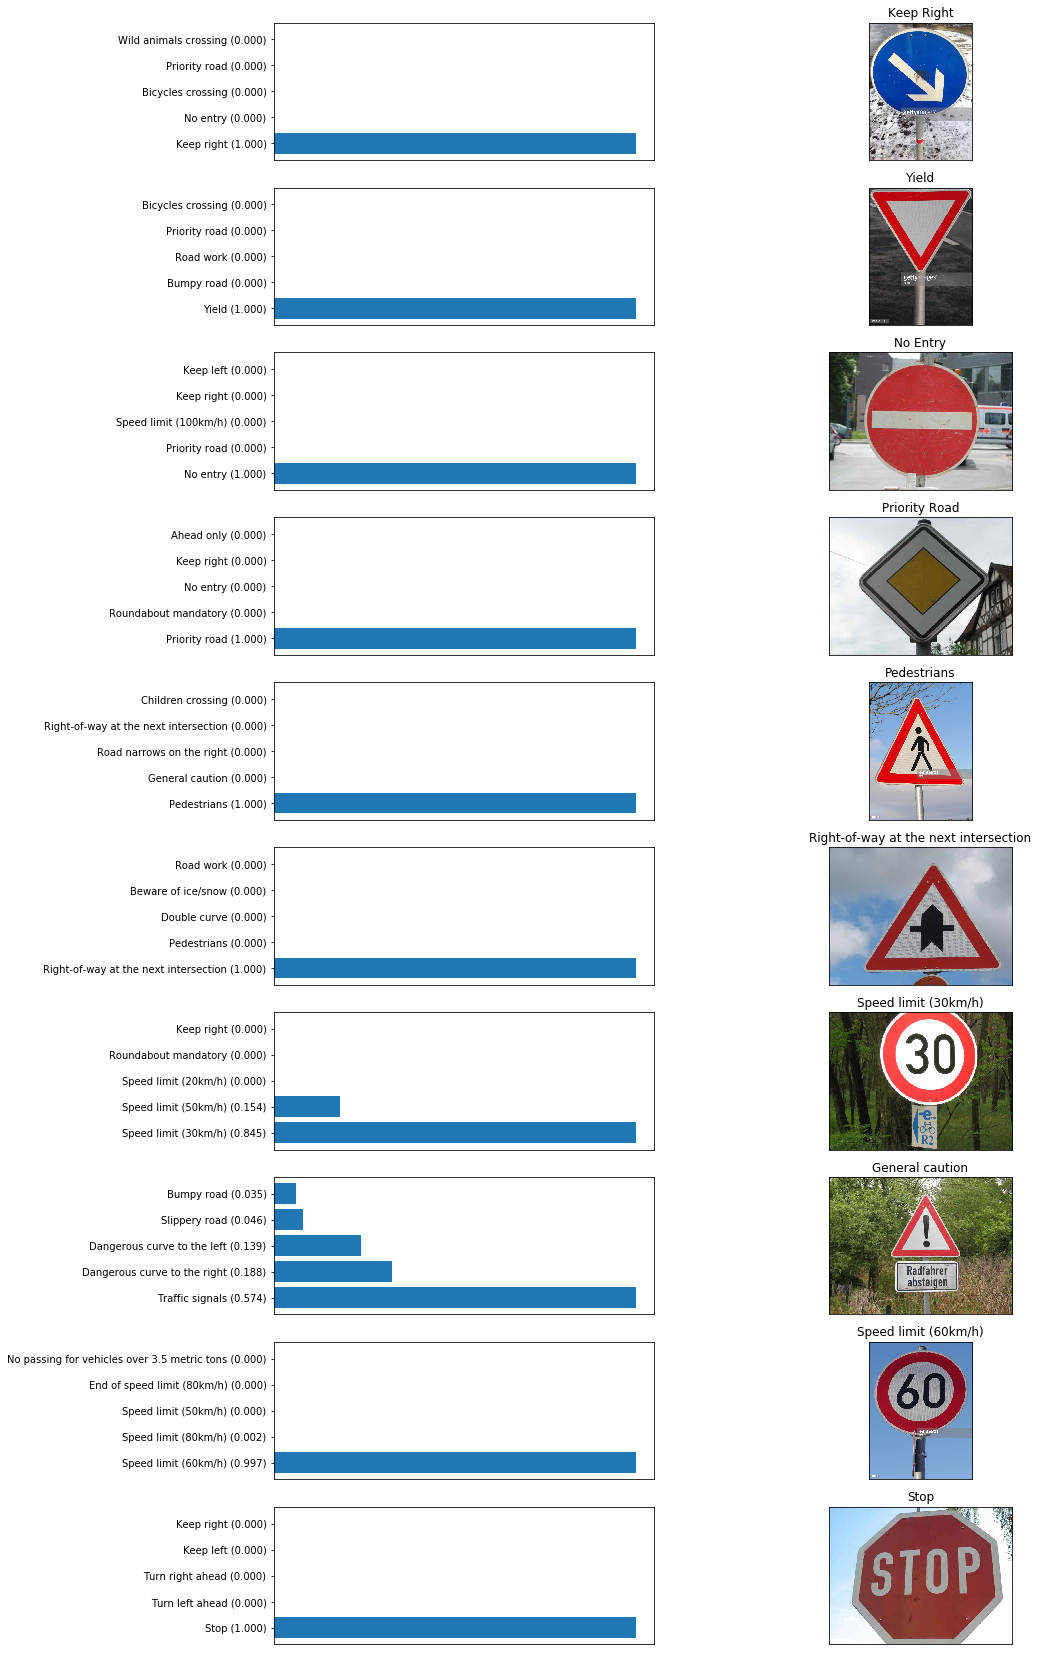

In [1112]:
probs = probabilities[0]
top_5_probs_values, top_5_probs_indices = [], []
with tf.Session() as sess:
    for probs in probabilities:
        vals, indices = sess.run(tf.nn.top_k(tf.constant(probs), k=5))
        top_5_probs_values.append(vals)
        top_5_probs_indices.append(indices)
'''
'''
plt.figure(figsize=(15, 45))
for i in range(len(novel_labels)):
    plt.subplot(15, 2, (2*i)+2)
    plt.imshow(novel_images[i]) 
    plt.title(sign_types[i])
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(15, 2, (2*i)+1)
    prob = top_5_probs_values[i]
    ind = top_5_probs_indices[i]
    plt.xticks([])
    plt.yticks([])
    plt.barh([j+1 for j in range(5)], prob)
    ytick_labels = []
    for sign_ind, sign_prob in zip(ind, prob):
        ytick_labels.append('{} ({:.3f})'.format(
            signnames.iloc[sign_ind]['SignName'],
            sign_prob))
    plt.yticks([j+1 for j in range(5)], 
               ytick_labels)
plt.show()

Most of the predictions seem sensible. Given the imperfect predictions, though, it seems that more images, especially of "General caution" signs, should be obtained and used for training.